# Imports

In [21]:
import psycopg2
import psycopg2.extras

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Section A: Getting Data by kaggle API

## A.1 First we need to add our kaggle.jason file (extracted from kaggle account) to our computer directory.

In [2]:
%cd 
#!mkdir ~/.kaggle
#!mv kaggle.json ~/.kaggle

C:\Users\kjama


## A.2 Reviewing Covid related dataset from kaggle

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
!kaggle datasets list -s "Covid"

ref                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
imdevskp/corona-virus-report                       COVID-19 Dataset                                     19MB  2020-08-07 03:47:47         181865       1535  1.0              
sudalairajkumar/covid19-in-india                   COVID-19 in India                                   758KB  2021-08-11 04:14:10         147749       1740  0.9117647        
gpreda/covid-world-vaccination-progress            COVID-19 World Vaccination Progress                   2MB  2022-02-10 18:23:57          75482       1996  1.0              
roche-data-science-coalition/uncover               UNCOVER COVID-19 Challenge                          258MB  2021-10-31 00:0

## 3 Downloading data

In [4]:
api.dataset_download_files('imdevskp/corona-virus-report',unzip=True)

In [5]:
Covid_set_name="country_wise_latest.csv"
data=pd.read_csv(Covid_set_name)
data.head(5)

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa


#  Section B: Fixing data Columns for PostgreSQL queries synatx

## B.1 Replacing signs  ( `~!@#$%^&*)(-+=,.?/\|  ) with underscore (_)

In [6]:
modfied_columns={}
for column_I in data.columns:
    new_column=column_I
    for operations in " `~!@#$%^&*)(-+=,.?/\|":
        new_column=new_column.replace(operations, "_")
    modfied_columns[column_I]=new_column
data.rename(columns = modfied_columns,inplace = True)
data.head()

,Country_Region,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered,Deaths___100_Cases,Recovered___100_Cases,Deaths___100_Recovered,Confirmed_last_week,1_week_change,1_week___increase,WHO_Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa


## B.2 Adding Underscore (_) before number starting columns

In [7]:
modfied_columns2={}
for column_I in data.columns:
    first_char=column_I[0]
    if first_char in "0123456789":
        first_char= "_" + first_char
        new_column=first_char + column_I[1:]     
        modfied_columns2[column_I]=new_column
data.rename(columns = modfied_columns2,inplace = True)
data.head()

,Country_Region,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered,Deaths___100_Cases,Recovered___100_Cases,Deaths___100_Recovered,Confirmed_last_week,_1_week_change,_1_week___increase,WHO_Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa


## B.3 outputing processed dataset for copying into PostgreSQL

In [8]:
data.to_csv('sqldata.csv',index=False)
sql_data=pd.read_csv('sqldata.csv')
sql_data.head()

,Country_Region,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered,Deaths___100_Cases,Recovered___100_Cases,Deaths___100_Recovered,Confirmed_last_week,_1_week_change,_1_week___increase,WHO_Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa


# SectionC: Copying data into PosgreSQL


## C1. Building automatic query for : Create table

In [9]:
def Create_table_query(data,Table_name,PK_index=0):
    Ptype_adjustment={"<class 'str'>":"varchar" ,
                  "<class 'numpy.int64'>":"int","<class 'int'>":"int",
                  "<class 'numpy.float64'>":"float(24)","<class 'float'>":"float(24)" }

    query=f'Create Table {Table_name} ({data.columns[PK_index]} {Ptype_adjustment[str(type(data.iloc[0,PK_index]))]} PRIMARY KEY,'
    for index,value in enumerate(data.columns):
        if index != PK_index:
            query=f'{query} {data.columns[index]} {Ptype_adjustment[str(type(data.iloc[0,index]))]},'


    new_query = list(query)
    new_query[-1] = ')'
    new_query=''.join(new_query)
    new_query=new_query +";"
    new_query
    return new_query

Create_table_query(data,"covid_set",0)

'Create Table covid_set (Country_Region varchar PRIMARY KEY, Confirmed int, Deaths int, Recovered int, Active int, New_cases int, New_deaths int, New_recovered int, Deaths___100_Cases float(24), Recovered___100_Cases float(24), Deaths___100_Recovered float(24), Confirmed_last_week int, _1_week_change int, _1_week___increase float(24), WHO_Region varchar);'

## C2. Building automatic query for : Copy table

In [10]:
def Create_Copy_Query(Path,Table_name):
    dataset=pd.read_csv(Path)
    headings=','.join(list(dataset.columns))
    newquery2= "COPY "+ Table_name+"(" + headings +") From " + "'" +Path + "'" + "DELIMITER ','" + "CSV HEADER;"
    return newquery2
Create_Copy_Query('C:/Mine/Ph.D/Semester 2/Intro to big data/Assignments/2022_GGE6505_AS03/sqldata.csv',"Covid_set") 

"COPY Covid_set(Country_Region,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered,Deaths___100_Cases,Recovered___100_Cases,Deaths___100_Recovered,Confirmed_last_week,_1_week_change,_1_week___increase,WHO_Region) From 'C:/Mine/Ph.D/Semester 2/Intro to big data/Assignments/2022_GGE6505_AS03/sqldata.csv'DELIMITER ','CSV HEADER;"

## C.3 Copying data into PostgreSQL

In [12]:
def Copy_to_SQL(Path,Table_name,PK_index=0):
    #Initialization
    conn = psycopg2.connect(database="GGE6505_AS03",user='postgres',
                            password="__",host="localhost", port='5432')
    conn.autocommit = True
    cursor = conn.cursor()
    # reading data into dataframe
    dataset=pd.read_csv(Path)
    # creating table
    SQL_Create_table = Create_table_query(data,Table_name,PK_index)
    cursor.execute(SQL_Create_table)
    # Copy table
    SQL_Copy_table = Create_Copy_Query(Path,Table_name)
    cursor.execute(SQL_Copy_table)
    #Finalization
    conn.commit()
    conn.close()

Copy_to_SQL(Path='C:/Mine/Ph.D/Semester 2/Intro to big data/Assignments/2022_GGE6505_AS03/sqldata.csv',
            Table_name="mytbl4",
            PK_index=0)


## C.4 Query_execution

In [13]:
def Execute_Query(SQL):
    #Initialization
    conn = psycopg2.connect(database="GGE6505_AS03",user='postgres',
                            password="__",host="localhost", port='5432')
    conn.autocommit = True
    cursor = conn.cursor()
    
    cursor.execute(SQL)
    colnames = [desc[0] for desc in cursor.description]
    df=pd.DataFrame(columns= colnames)
    for i in cursor.fetchall():
        to_append = list(i)
        df_length = len(df)
        df.loc[df_length] = to_append
          
    #Finalization
    conn.commit()
    conn.close()
    return df
    

In [91]:
SQL1="Select country_region,deaths,Confirmed,who_region From mytbl ORDER BY deaths DESC LIMIT 4"
df_sql1=Execute_Query(SQL1)
df_sql1

,country_region,deaths,confirmed,who_region
0,US,148011,4290259,Americas
1,Brazil,87618,2442375,Americas
2,United Kingdom,45844,301708,Europe
3,Mexico,44022,395489,Americas


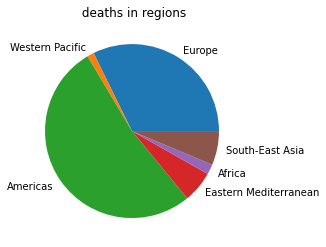

In [50]:
SQL2="Select SUM(deaths),who_region From mytbl GROUP BY who_region"
df_sql2=Execute_Query(SQL2)
plt.pie(df_sql2["sum"],  labels= df_sql2["who_region"])
plt.title(" deaths in regions")
plt.show()

# EnD